<a href="https://colab.research.google.com/github/averyrair/ChessBAKEN/blob/main/PositionEvaluation/howMagnusCarlsenEvaluator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chess
!pip install stockfish
!apt install stockfish

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 0s (55.6 MB/s)
Selecting previously unselected package stockfish.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
#@title Import PGN and Export CSV

import chess.pgn
#if not os.path.exists(os.path.join(chess_dir, 'moveSelectorDataset.csv')):
if 0:
  pgn_dir = os.path.join(chess_dir, 'KingBase2019-pgn')
  pgnFiles = [os.path.join(pgn_dir, f) for f in os.listdir(pgn_dir) if f.endswith('.pgn')]

  # Read every PGN file in the directory.
  iterator = 0
  for pgnFile in pgnFiles:
    print(pgnFile)
    pgn = open(pgnFile)

    # Prepare CSV to export dataset.
    with open(os.path.join(chess_dir, 'moveSelectorDataset' + pgnFile[74:81] +'.csv'), 'w') as csvfile:
      csvwriter = csv.writer(csvfile)
      #csvwriter.writeheader(['Label', 'Input'])

      # Read every game in the PGN file.
      while True:
        game = chess.pgn.read_game(pgn)
        if game is None: break
        iterator += 1
        if iterator % 500 == 0:
          print(iterator)
          #break
        board = game.board()

        # New data point for every move in the game.
        gameMoves = list(game.mainline_moves())
        for i in range(len(gameMoves)-1):
          board.push(gameMoves[i])
          csvwriter.writerow([gameMoves[i+1], board.fen().split(" ")[0]])

In [ ]:
import chess
import csv

# The number of possible pieces and square states (8*8*6*2)
NUM_BOARD_NODES = 768

# Generate the mapping matrix (only needs to be done once)
def getMappingMatrix():
    moveMap = [[[[0 for l in range(8)] for k in range(
        8)] for j in range(8)] for i in range(8)]
    offset = 0
    for i in range(8):
        for j in range(8):
            for k in range(8):
                for l in range(8):
                    if canMove((i, j), (k, l)):
                        moveMap[i][j][k][l] = offset
                        offset += 1
    return moveMap

# Encode a board position and legal moves into a binary array
def encodeSelector(boardFEN, moves, moveMap):
    # Encode board position
    encodedBoard = [0 for _ in range(NUM_BOARD_NODES)]
    rowsFEN = boardFEN.split('/')
    for i in range(8):
        col = 0
        for j in range(len(rowsFEN[i])):
            if rowsFEN[i][j].isdigit():
                col += ord(rowsFEN[i][j])-48
            else:
                match rowsFEN[i][j]:
                    case 'P':
                        idx = (8*6*2*col) + (6*2*i) + (0*2) + 0
                        encodedBoard[idx] = 1
                    case 'N':
                        idx = (8*6*2*col) + (6*2*i) + (1*2) + 0
                        encodedBoard[idx] = 1
                    case 'B':
                        idx = (8*6*2*col) + (6*2*i) + (2*2) + 0
                        encodedBoard[idx] = 1
                    case 'R':
                        idx = (8*6*2*col) + (6*2*i) + (3*2) + 0
                        encodedBoard[idx] = 1
                    case 'Q':
                        idx = (8*6*2*col) + (6*2*i) + (4*2) + 0
                        encodedBoard[idx] = 1
                    case 'K':
                        idx = (8*6*2*col) + (6*2*i) + (5*2) + 0
                        encodedBoard[idx] = 1
                    case 'p':
                        idx = (8*6*2*col) + (6*2*i) + (0*2) + 1
                        encodedBoard[idx] = 1
                    case 'n':
                        idx = (8*6*2*col) + (6*2*i) + (1*2) + 1
                        encodedBoard[idx] = 1
                    case 'b':
                        idx = (8*6*2*col) + (6*2*i) + (2*2) + 1
                        encodedBoard[idx] = 1
                    case 'r':
                        idx = (8*6*2*col) + (6*2*i) + (3*2) + 1
                        encodedBoard[idx] = 1
                    case 'q':
                        idx = (8*6*2*col) + (6*2*i) + (4*2) + 1
                        encodedBoard[idx] = 1
                    case 'k':
                        idx = (8*6*2*col) + (6*2*i) + (5*2) + 1
                        encodedBoard[idx] = 1
                col += 1

    # Combine into single list
    return encodedBoard

In [ ]:
# Test the encoder and decoder
def testEncodeDecode():
    # Encode board
    moveMap = getMappingMatrix()
    with open('MoveSelector/moveSelectorDataset.csv', 'r') as file:
        data = list(csv.reader(file))
    curr = data[250]
    encoded = encodeSelector(curr[1], curr[2], moveMap)

testEncodeDecode()

In [ ]:
import requests

# Magnus Carlsen's Lichess username is "DrNykterstein"
LICHESS_API = "https://lichess.org/api/games/user/DrNykterstein"

def download_games(username, max_games=10):
    """Download Magnus Carlsen's games from Lichess."""
    params = {
        "max": max_games,
        "moves": "true",
        "pgnInJson": "true",
        "evals": "false"
    }
    response = requests.get(f"https://lichess.org/api/games/user/{username}", params=params)

    if response.status_code == 200:
        return response.text
    else:
        print(f"Error: {response.status_code}")
        return None

pgn_games = download_games("DrNykterstein", max_games=5000)

In [ ]:
import chess
import chess.pgn
import io

def extract_positions_from_pgn(pgn_data):
    positions = []

    # Create a file-like object from the PGN string
    pgn_io = io.StringIO(pgn_data)
    while True:
        # Read a PGN
        game = chess.pgn.read_game(pgn_io)
        if game is None:
            break

        white_player = game.headers.get("White", "")
        black_player = game.headers.get("Black", "")
        result = game.headers.get("Result", "")

        # Extract the label for who won the game
        if white_player == "DrNykterstein":
            label = 1.0 if result == "1-0" else 0.0 if result == "0-1" else None
        elif black_player == "DrNykterstein":
            label = 1.0 if result == "0-1" else 0.0 if result == "1-0" else None
        else:
            label = None

        # Save all of the board positions for that game and set the label
        # to 1 if he won and 0 if he lost
        # If it was a tie, don't include positions from that game
        if label is not None:
            board = game.board()
            for move in game.mainline_moves():
                board.push(move)
                positions.append((board.fen(), label))

    return positions

board_positions = extract_positions_from_pgn(pgn_games)

In [ ]:
def king_safety(board):
    white_king_square = board.king(chess.WHITE)
    black_king_square = board.king(chess.BLACK)

    # Helper function to evaluate safety of a king given its position and color
    def evaluate_king(board, king_square, color):
        if king_square is None:
            return 0

        # Get the king's coordinates
        safety_score = 1.0
        file = chess.square_file(king_square)
        rank = chess.square_rank(king_square)

        # Check where the pawns are shielding the king
        pawn_squares = [
            chess.square(file + file_offset, rank + (1 if color == chess.WHITE else -1))
            for file_offset in [-1, 0, 1]
            if 0 <= file + file_offset < 8 and 0 <= rank + (1 if color == chess.WHITE else -1) < 8
        ]

        # Adjust the safety score by the amount of pawns protecting the king
        pawn_shield = sum(1 for sq in pawn_squares if board.piece_at(sq) and board.piece_at(sq).symbol().lower() == 'p')
        safety_score -= (3 - pawn_shield) * 0.1

        # Check for open files that the king is on
        file = chess.square_file(king_square)
        open_file_penalty = 0.2 if all(board.piece_at(chess.square(file, r)) is None for r in range(8)) else 0
        safety_score -= open_file_penalty

        enemy_pieces = sum(1 for sq in chess.SQUARES if board.is_attacked_by(not color, sq) and chess.square_distance(sq, king_square) <= 2)
        safety_score -= min(enemy_pieces * 0.05, 0.3)

        # Check the mobility of the king
        king_moves = len(list(board.legal_moves))
        mobility_penalty = 0.2 if king_moves < 2 else 0
        safety_score -= mobility_penalty

        # Penalize if the king is in check
        if board.is_check():
            safety_score -= 0.3

        return max(0, min(safety_score, 1))

    white_safety = evaluate_king(board, white_king_square, chess.WHITE)
    black_safety = evaluate_king(board, black_king_square, chess.BLACK)

    return white_safety, black_safety

In [ ]:
def piece_safety(board):
    # Assign values to pieces
    piece_values = {
        chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
        chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0
    }

    white_safety = 0
    black_safety = 0

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Check if the piece is under attack
            attackers = board.attackers(not piece.color, square)
            if attackers:
                # Penalize the score if the piece is under attack
                piece_value = piece_values.get(piece.piece_type, 0)
                if piece.color == chess.WHITE:
                    white_safety -= piece_value
                else:
                    black_safety -= piece_value

    return white_safety, black_safety

In [ ]:
def evaluate_material(board):
    # Assign values to pieces
    piece_values = {
        chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
        chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0
    }

    white_score = 0
    black_score = 0

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Retrieve the material value of the pieces
            value = piece_values.get(piece.piece_type, 0)
            if piece.color == chess.WHITE:
                white_score += value
            else:
                black_score += value

    return white_score, black_score

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def fen_to_array(fen):
    # Set a mapping to all of the pieces
    piece_map = {
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
        '.': 0
    }

    # Create a board
    board = chess.Board(fen)
    board_array = np.zeros(64, dtype=int)

    # Fill the board with pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        board_array[square] = piece_map.get(piece.symbol(), 0) if piece else 0

    # Calculate features for the given board position
    white_king_safety, black_king_safety = king_safety(board)
    white_piece_safety, black_piece_safety = piece_safety(board)
    white_material, black_material = evaluate_material(board)

    return np.append(board_array, [
        white_king_safety, black_king_safety,
        white_piece_safety, black_piece_safety,
        white_material, black_material
    ])

X = []
y = []
for fen, label in board_positions:
    try:
        X.append(fen_to_array(fen))
        y.append(label)
    except:
        continue

# for fen, label in board_positions:
#     X.append(fen_to_array(fen))
#     y.append(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 300643
Testing set size: 75161


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Simple NN architeture
class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        # self.fc1 = nn.Linear(64, 128)
        self.fc1 = nn.Linear(70, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create the model, loss, and optimizer
model = ChessNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert np arrays to tensors
X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)

loss_vals = []
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    loss_vals.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.7728838324546814
Epoch 100, Loss: 0.5761255025863647
Epoch 200, Loss: 0.5474900007247925
Epoch 300, Loss: 0.5280006527900696
Epoch 400, Loss: 0.5154229998588562
Epoch 500, Loss: 0.5073382258415222
Epoch 600, Loss: 0.49986737966537476
Epoch 700, Loss: 0.4944581687450409
Epoch 800, Loss: 0.48951077461242676
Epoch 900, Loss: 0.48519501090049744


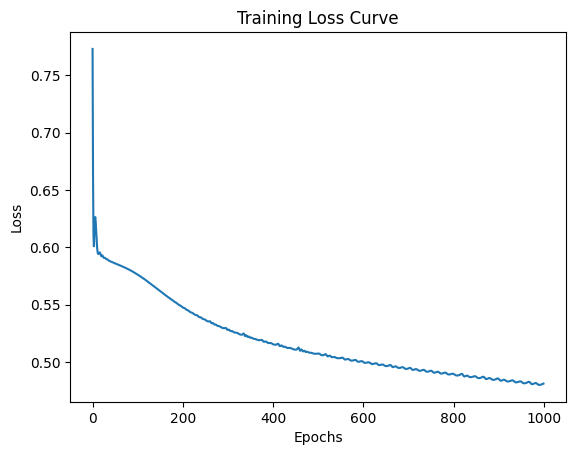

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_vals)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Convert test dataset to tensors
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1)

# Set the model evaluation mode
model.eval()

# Disable gradients to pass through the NN
with torch.no_grad():
    output = model(X_test)

# Threshold the output only to check the accuracy of the model compared
# to the labels
predictions = (output >= 0.5).float()

accuracy = accuracy_score(y_test.numpy(), predictions.numpy())

print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate loss on the test dataset
criterion = torch.nn.BCELoss()
test_loss = criterion(output, y_test)
print(f"Test Loss: {test_loss.item()}")

Test Accuracy: 74.81%
Test Loss: 0.5323767066001892


In [ ]:
# How Magnus Carlsen is a move

pos = X_test[0]
true = y_test[0]

print(pos)
print(true)

with torch.no_grad():
    output = model(pos)
    prediction = output

print(prediction)

tensor([ 4.0000,  2.0000,  3.0000,  5.0000,  6.0000,  0.0000,  0.0000,  4.0000,
         1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,  3.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -2.0000, -1.0000,  0.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.0000,  0.0000, -1.0000,
        -4.0000, -2.0000, -3.0000, -5.0000, -6.0000, -3.0000,  0.0000, -4.0000,
         0.9000,  0.9000,  0.0000,  0.0000, 39.0000, 39.0000])
tensor([1.])
tensor([0.6919])
